# Zonal energy spectrum derivations

In [5]:
import pyshtools
import numpy as np
import xarray as xr

# ------------------------ #
# need manual install
from weatherbench2.derived_variables import ZonalEnergySpectrum
# ref
# https://github.com/google-research/weatherbench2/blob/47d72575cf5e99383a09bed19ba989b718d5fe30/weatherbench2/derived_variables.py

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
RAD_EARTH = 6371000

def zonal_energy_spectrum_sph(ds_input: xr.Dataset, 
                              varname: str) -> xr.DataArray:
    '''
    Computes the Zonal Energy Spectrum of a variable in an xarray.Dataset 
    using spherical harmonic transform. The output is rescaled by the 
    mean circumference per longitude grid.
    
    Parameters:
    - ds_input: xarray.Dataset containing the data.
    - varname: Name of the variable to compute the spectrum for.

    Returns:
    - spectrum: xarray.DataArray containing the zonal energy spectrum.
    '''
    
    data = ds_input[varname]

    # check 'latitude' and 'longitude' cooridnate names
    if 'latitude' not in data.dims or 'longitude' not in data.dims:
        raise ValueError("Data must have 'latitude' and 'longitude' dimensions")
        
    latitudes = data['latitude'].values
    longitudes = data['longitude'].values

    # check latitudes for [90, -90] descending order
    # if not flip data and latitude
    if latitudes[0] < latitudes[-1]:
        data = data.isel(latitude=slice(None, None, -1))
        latitudes = data['latitude'].values
        
    # check longitudes for [0, 360] order
    # if not re-organize
    if np.any(longitudes < 0):
        longitudes = (longitudes + 360) % 360
        sorted_indices = np.argsort(longitudes)
        data = data.isel(longitude=sorted_indices)
        longitudes = data['longitude'].values

    # number of grids
    nlat = len(latitudes)
    nlon = len(longitudes)
    
    # max wavenumber is half of the latitude grids -1
    max_wavenum = (nlat - 1) // 2  # int divide
    
    # allocate zonal wavenumbers ranges
    zonal_wavenumbers = np.arange(max_wavenum + 1)

    def compute_power_m(data_array_2d):
        '''
        Computes the power spectrum for a 2D data array using spherical harmonics.

        Parameters:
        - data_array_2d: 2D numpy array of shape (nlat, nlon)

        Returns:
        - power_m: 1D numpy array of power corresponding to each zonal wavenumber m
        '''
        # initialize SHGrid
        grid = pyshtools.SHGrid.from_array(data_array_2d)
        
        # expand the grid to spherical harmonic coefs
        coeffs = grid.expand(normalization='ortho', lmax_calc=max_wavenum)

        # power per degree per order. shape=(lmax+1, lmax+1)
        coeffs_squared = coeffs.coeffs[0]**2 + coeffs.coeffs[1]**2
        
        # allocate power array for each zonal wavenumber m
        power_m = np.zeros(max_wavenum + 1)
        
        # sum over degrees l >= m for each order m to get the total power
        for m in range(max_wavenum + 1):
            power_m[m] = np.sum(coeffs_squared[m:, m])

        return power_m

    # xr.apply_ufunc scope
    spectrum = xr.apply_ufunc(
        compute_power_m,
        data,
        input_core_dims=[['latitude', 'longitude']],
        output_core_dims=[['zonal_wavenumber']],
        vectorize=True,
        dask='parallelized',  # <-- dask parallelization
        output_dtypes=[float],
    )

    # assign new coordinate 'zonal_wavenumber'
    spectrum = spectrum.assign_coords(zonal_wavenumber=zonal_wavenumbers)
    
    # re-scale power spectrum based on the mean circumference per longitude
    cos_latitudes = np.cos(np.deg2rad(latitudes))
    normalization_factor = (RAD_EARTH * np.sum(cos_latitudes)) / nlon
    
    spectrum = spectrum * normalization_factor
    
    return spectrum

def zonal_energy_spectrum_fft(ds_input: xr.Dataset, 
                              varname: str) -> xr.DataArray:
    '''
    Computes the Global Zonal Energy Spectrum of a variable in an xarray.Dataset 
    using FFT. Latitude-specific values are integrated to represent the 
    energy spectrum for the entire Earth.
    (the function agrees with ZonalEnergySpectrum in weatherbench2.derived_variables)
    
    Parameters:
    - ds_input: xarray.Dataset containing the data.
    - varname: Name of the variable to compute the spectrum for.
    
    Returns:
    - global_spectrum_weighted: xarray.DataArray containing the global zonal energy spectrum.
    '''
    
    def _circumference(latitude):
        """Compute Earth's circumference at each latitude."""
        circum_at_equator = 2 * np.pi * RAD_EARTH
        return np.cos(np.deg2rad(latitude)) * circum_at_equator

    def FFT_power(f_x):
        '''
        Compute power spectrum using FFT.

        Parameters:
        - f_x: 1D numpy array representing data along longitude.

        Returns:
        - power_k: 1D numpy array of power at each zonal wavenumber.
        '''
        
        f_k = np.fft.rfft(f_x, norm='forward')  # normalize by 1/N
        power_k = np.real(f_k * np.conj(f_k))
        power_k[1:-1] *= 2  # Double power for positive frequencies except DC and Nyquist
        return power_k

    # =================================================================================== #
    # main
    data = ds_input[varname]
    
    # check 'latitude' and 'longitude' cooridnate names
    if 'latitude' not in data.dims or 'longitude' not in data.dims:
        raise ValueError("Data must have 'latitude' and 'longitude' dimensions")
    
    # xr.apply_ufunc scope
    spectrum = xr.apply_ufunc(
        FFT_power,
        data,
        input_core_dims=[['longitude']],
        output_core_dims=[['zonal_wavenumber']],
        exclude_dims={'longitude'},
        vectorize=True,
        dask='parallelized',  # <-- dask parallelization
        output_dtypes=[float],
    )

    # define max_wavenum
    nlat = len(ds_input.latitude)
    max_wavenum = (nlat - 1) // 2

    # get the spectrum based on max_wavenum
    spectrum = spectrum.isel(zonal_wavenumber=slice(0, max_wavenum + 1))
    spectrum = spectrum.assign_coords(zonal_wavenumber=range(0, max_wavenum + 1))

    # compute frequencies and wavelengths
    base_frequency = np.fft.rfftfreq(len(ds_input.longitude))
    frequency = base_frequency[:max_wavenum + 1]

    # assign xarray coords
    spectrum = spectrum.assign_coords(
        frequency=('zonal_wavenumber', frequency)
    )
    spectrum['frequency'] = spectrum.frequency.assign_attrs(units='1 / m')

    wavelength = 1 / frequency
    spectrum = spectrum.assign_coords(
        wavelength=('zonal_wavenumber', wavelength)
    )
    spectrum['wavelength'] = spectrum.wavelength.assign_attrs(units='m')

    # get Earth's circumference per latitude
    circumference = _circumference(ds_input.latitude)

    # weight the spectrum by the circumference
    spectrum_weighted = spectrum  * circumference

    # calculate mean spectrum (as in weatherbench2) 
    mean_spectrum = spectrum_weighted.mean(dim='latitude')
    
    return mean_spectrum

In [13]:
# ========================================================================= #
# example data (lat/lon)
nlat = 100
nlon = 200
latitudes = np.linspace(90, -90, nlat)
longitudes = np.linspace(0, 360, nlon)
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# example data (a variable)
data_values = 0.01 * np.sin(2*np.deg2rad(lat_grid)) * np.cos(3 * np.deg2rad(lon_grid))

# numpy to xr.dataset
data = xr.DataArray(
    data_values,
    dims=('latitude', 'longitude'),
    coords={'latitude': latitudes, 'longitude': longitudes},
    name='test_variable',
    attrs={'units': 'unitless'}
)

ds_input = xr.Dataset({'test_variable': data})

# ========================================================================= #
# comparisons

# FFT-based zonal energy spectrum
result_fft = zonal_energy_spectrum_fft(ds_input, 'test_variable')

# original weatherbench2
calc = ZonalEnergySpectrum('test_variable')
result_fft2 = calc.compute(ds_input)
result_fft2 = np.mean(np.array(result_fft2), axis=0)

# SH based zonal spectrum
result_sph = zonal_energy_spectrum_sph(ds_input, 'test_variable')

/glade/derecho/scratch/ksha/tmp/ipykernel_62814/1021180966.py:176: RuntimeWarning: divide by zero encountered in divide
  wavelength = 1 / frequency


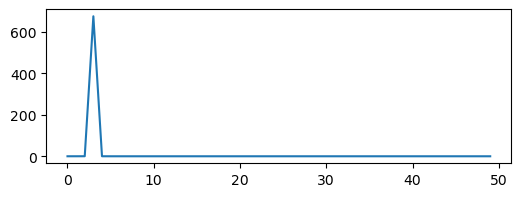

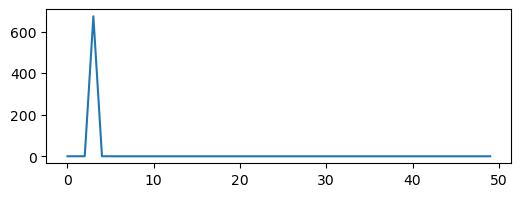

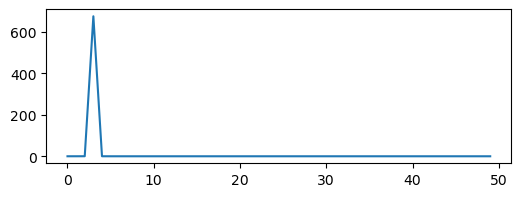

In [17]:
plt.figure(figsize=(6, 2))
plt.plot(result_fft)
plt.figure(figsize=(6, 2))
plt.plot(result_sph)
plt.figure(figsize=(6, 2))
plt.plot(result_fft2[:nlat//2]) # weatherbench2 didnt truncate wavenumber after FFT